In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from omegaconf import OmegaConf
from plaid.datasets import NUM_ORGANISM_CLASSES, NUM_FUNCTION_CLASSES
import hydra
from plaid.pipeline import SampleLatent

device = torch.device("cuda")

/homefs/home/lux70/code/plaid/src/plaid/denoisers/modules/_attention.py:12: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  from xformers.components.attention import ScaledDotProduct


# Sample

In [13]:
(235 - 190) / 2

22.5

In [15]:
organism_idx = 3585
function_idx = 1658
print(organism_idx, function_idx)

3585 1658


In [16]:
device = torch.device("cuda")
diffusion = diffusion.to(device)

In [29]:


cfg = OmegaConf.load("/homefs/home/lux70/code/plaid/configs/pipeline/sample/sample_latent.yaml")

N, L = 32, 24
assert L % 4 == 0
shape = (N, L, input_dim)

cfg['function_idx'] = function_idx
cfg['organism_idx'] = organism_idx
cfg['length'] = L
cfg['num_samples'] = N
cfg['cond_scale'] = 2
cfg['sampling_timesteps'] = 500

solver = hydra.utils.instantiate(cfg)
x = solver.sample()

/homefs/home/lux70/code/plaid/src/plaid/pipeline/_sample.py:165: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(model_path)


sampling loop time step:   0%|          | 0/500 [00:00<?, ?it/s]

# Decode

In [30]:
from cheap.pretrained import load_model_from_id
cheap_model = load_model_from_id(compression_model_id)
_ = cheap_model.to(device)

from cheap.proteins import LatentToSequence,LatentToStructure
latent_to_sequence = LatentToSequence()
latent_to_sequence.to(device)

latent_to_structure = LatentToStructure()
latent_to_structure.to(device)

/homefs/home/lux70/code/cheap-proteins/src/cheap/pretrained.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_fpath)


Using tanh layer at bottleneck...
Finished loading HPCT model with shorten factor 2 and 32 channel dimensions.


/homefs/home/lux70/code/cheap-proteins/src/cheap/decoder.py:92: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path)
Creating ESMFold...
ESMFold model 

In [31]:
sampled_latent = x

print(sampled_latent.shape)
final_sample = sampled_latent[:, -1, :, :]
print(final_sample.shape)

print(final_sample.max(), final_sample.min())

sampled_uncompressed = cheap_model.decode(final_sample, downsampled_mask=None)
print(sampled_uncompressed.min(), sampled_uncompressed.max())

from cheap.utils import LatentScaler
latent_scaler = LatentScaler()
sampled_unscaled = latent_scaler.unscale(sampled_uncompressed) 

torch.Size([32, 501, 24, 32])
torch.Size([32, 24, 32])
tensor(1.0082, device='cuda:0') tensor(-0.9504, device='cuda:0')
tensor(-0.8243, device='cuda:0') tensor(0.8281, device='cuda:0')


In [32]:
sequences = latent_to_sequence.to_sequence(sampled_unscaled)[-1]
sequences[:3]

['NDPDAGAGSDLRRHSGLQTVALAQEAQWKSKKAPNYFVNFSLHGQCHF',
 'MSFSVEKMRVKFSEFNIGGDENGYYRYIPKPSAKNPRYYYDNNGLYTV',
 'DERLVKSMWDGCNGIGNWFESNEGKVGPLALRAGDAVSDGVNLARGLI']

In [33]:
pdb_strs, raw_outputs = latent_to_structure.to_structure(sampled_unscaled, return_raw_outputs=True, sequences=sequences, batch_size=32, num_recycles=1)

(Generating structure): 100%|██████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.65s/it]


# Visualize

/tmp/ipykernel_1638500/2582915834.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(raw_outputs['plddt'].mean(dim=-1).mean(dim=-1).cpu().numpy(), bins=30)


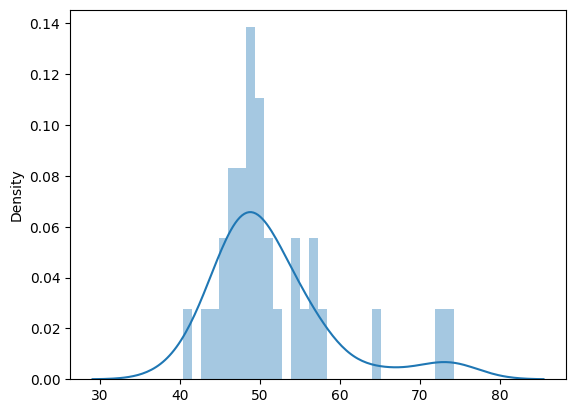

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

_ = sns.distplot(raw_outputs['plddt'].mean(dim=-1).mean(dim=-1).cpu().numpy(), bins=30)

In [35]:
import py3Dmol

# for i in range(len(pdb_strs)):
# for i in range(10,20): 
# for i in range(0, 10): 
for i in range(30): 
    view = py3Dmol.view(width=600, height=600)
    view.addModelsAsFrames(pdb_strs[i])
    
    # Apply the plDDT color scheme
    # view.setStyle({'cartoon': {'color': {'prop': 'b', 'gradient': 'roygb', 'min': 0, 'max': 100}}})
    view.setStyle({'cartoon': {'color': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    
    # # Add surface representation with plDDT-based color
    view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}})
    # view.addSurface(py3Dmol.VDW, {'opacity': 0.7, 'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 0, 'max': 100}})

    view.zoomTo()
    view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

3Dmol.js failed to load for some reason. Please check your browser console for error messages.